# Functional connectivity profiles

## Load packages

In [1]:
# General
import numpy as np
import pandas as pd
import os
import csv

# Computing
import scipy.io
from scipy import stats
from heapq import nlargest  # gives you the largest values of a list

# Visualization
import matplotlib.pyplot as plt

# Gradients
import brainspace
from brainspace.datasets import load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels

## Define directories

In [2]:
codedir = os.path.abspath('')  # obtain current direction from which script is runnning

datadir = '/data/p_02667/sex_diff_gradients/data/'
datadir_geodesic = '/data/p_02721/geodesic_HCP/mica_pipe/output/micapipe/'

resdir_hcp = '/data/p_02667/sex_diff_gradients/results/HCP/'
resdir_fig = '/data/p_02667/sex_diff_gradients/results/figures/'

In [3]:
path_list = os.listdir(datadir_geodesic)
path_list.sort()

# Data

## Import the Yeo 7 network coding for the Schaefer 400 parcellation scheme 

(i.e., which network each parcel belongs to)



- **So a parcel cannot belong to more than 1 network..? LIMITATION NO? -> Yes. Shanmugan et al. (2022) for example use loading onto a network (i.e., not discrete)** 

In [4]:
# labels: 1=visual, 2=sensory motor, 3=dorsal attention, 4=ventral attention, 5=limbic, 6=fronto parietal, 7= DMN

with open(datadir+'yeo_7.csv') as f:
    reader = csv.reader(f)
    yeo7_networks = list(reader)[0]  # need [0] because the network values are contained in double brackets [[ ]]

Plotting the 7 Yeo networks on cortical surface

**TO DO:**
- no option of a map with 7 colors..? https://matplotlib.org/stable/tutorials/colors/colormaps.html
- there must be a better way of labelling the maps with actual names of networks (ie categorical)? maybe not, not the purpose of this plot hemispheres function


/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


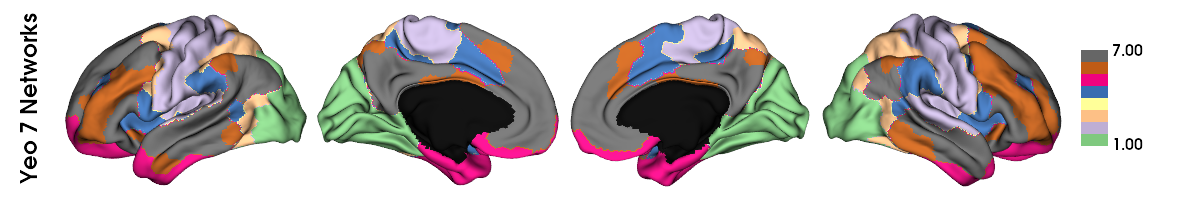

In [5]:
# need the the yeo network values (=dummy coding) to be in array format & float type in order to map_to_labels
yeo7_networks_array = []

for i in yeo7_networks:
    yeo7_networks_array.append(float(i))

yeo7_networks_array = np.asarray(yeo7_networks_array)



# defining labeling scheme and mask
labeling = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()

mask = labeling != 0

networks = map_to_labels(yeo7_networks_array, labeling, mask=mask, fill=np.nan)  # mean_grad contains 10 .gradients_ (1 gradient per column) - here I take all rows and individual select column based on gradient I want (first 3)

plot_hemispheres(surf_lh, surf_rh, array_name=networks, embed_nb = True, size=(1200, 200), cmap='Accent', color_bar=True, label_text=['Yeo 7 Networks'], zoom=1.55)


## Network labels ('Accent' cmap):
# 1 visual (green)
# 2 sensory motor (purple)
# 3 dorsal attention (beige)
# 4 ventral attention (blue)
# 5 limbic (fuchsia)
# 6 fronto parietal (brown)
# 7 DMN (grey)

This palette is to be used for every time that Yeo networks are displayed in color (except (a) for showing the networks plotted on the hemispheres - this dictionary doesn't work as cmap for plot_hemispheres; (b) the pie charts - dictionary format not recognized)

In [6]:
# original Yeo network colors
palette_labeled_networks = {'DMN': 'indianred',  
                            'dorsal attention' : 'forestgreen',  
                            'fronto parietal' : 'orange',  
                            'limbic' : 'lemonchiffon',  
                            'sensory motor' : 'steelblue',
                            'ventral attention' : 'orchid', 
                            'visual' : 'darkorchid'} 

This is not needed for the raincloud plot, just for the scatterplot G1 v G2 displaying networks

In [7]:
# making an array with yeo network labels (names instead of numbers)
yeo7_networks_array_labels = []

for i in yeo7_networks:
    if i == '1':
        yeo7_networks_array_labels.append('visual')
    elif i == '2':
        yeo7_networks_array_labels.append('sensory motor')
    elif i == '3':
        yeo7_networks_array_labels.append('dorsal attention')
    elif i == '4':
        yeo7_networks_array_labels.append('ventral attention')
    elif i == '5':
        yeo7_networks_array_labels.append('limbic')
    elif i == '6':
        yeo7_networks_array_labels.append('fronto parietal')
    elif i == '7':
        yeo7_networks_array_labels.append('DMN')

yeo7_networks_array_labels = np.asarray(yeo7_networks_array_labels)

In [8]:
network_names = ["visual", "sensory motor", "DMN", "dorsal attention", "ventral attention", "limbic", "fronto parietal"]

print("Number of parcels in each Yeo network:")
for i in range(len(network_names)):
    print(f"- {network_names[i]}: {yeo7_networks_array_labels.tolist().count(network_names[i])}")

Number of parcels in each Yeo network:
- visual: 61
- sensory motor: 77
- DMN: 90
- dorsal attention: 46
- ventral attention: 47
- limbic: 26
- fronto parietal: 53


## Load fc data (needed to compute mean geodesic distance for top 10% of fc connections)

In [9]:
# fc matrices
scipy.io.whosmat(datadir+'fc_matrices/fc_matrices.mat')

[('HCP_fc_matrices', (1014, 400, 400), 'double'),
 ('HCP_sub_list_fc', (1014,), 'char'),
 ('GSP_fc_matrices', (1568, 400, 400), 'double'),
 ('GSP_sub_list_fc', (1568,), 'char')]

In [10]:
# taking the list of subjects that have fc data
HCP_sub_list_fc = scipy.io.loadmat(datadir+'fc_matrices/fc_matrices.mat')['HCP_sub_list_fc']

# taking the fc matrices from the mat file
fc_matrices_full = scipy.io.loadmat(datadir+'fc_matrices/fc_matrices.mat')['HCP_fc_matrices']

## Get subsample of fc matrices that has full data (matching HCP_sub_list_final)

In [11]:
HCP_sub_list_final = np.genfromtxt(datadir+'HCP_sub_list_final.csv', delimiter=',')
HCP_sub_list_final = np.array([str(int(e)) for e in HCP_sub_list_final])

In [12]:
# list that will contain the fc matrices in final sample
fc_matrices = []

for i in range(len(HCP_sub_list_fc)):
    if HCP_sub_list_fc[i] in HCP_sub_list_final:
        
        # append this subjects' list of fc matrices to the list of fc matrices in final sample
        fc_matrices.append(fc_matrices_full[i])
    
fc_matrices = np.array(fc_matrices)

In [13]:
fc_matrices.shape

(1000, 400, 400)

## Load demographics data to retrieve sex of subjects

In [14]:
HCP_demographics_cleaned_final = pd.read_csv(resdir_hcp+'demographics_cleaned_final.csv', index_col=0)

In [15]:
HCP_demographics_cleaned_final

,Subject,Age_in_Yrs,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,Race,...,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final,sex_num,TwinStatus,TwinStatus_num,Family_ID_num
1,100206,27,True,NotTwin,,56037_85858,56037,85858,NaN,White,...,49.7,72.63,72.03,1.84,0.0,1.84,0,sibling,2,115
2,100307,27,True,NotMZ,MZ,51488_81352,51488,81352,NaN,White,...,38.6,71.69,71.76,1.76,0.0,1.76,1,MZ,0,149
3,100408,33,True,MZ,MZ,51730_81594,51730,81594,NaN,White,...,52.6,114.01,113.59,1.76,2.0,1.68,0,MZ,0,38
4,100610,27,True,NotMZ,DZ,52813_82634,52813,82634,NaN,White,...,38.6,84.84,85.31,1.92,1.0,1.88,0,DZ,1,8
5,101006,35,True,MZ,,51283_52850_81149,51283,81149,NaN,Black or African Am.,...,38.6,123.80,123.31,1.80,0.0,1.80,1,MZ,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,992673,33,True,NotTwin,,56143_85963,56143,85963,NaN,White,...,38.6,101.63,99.26,1.80,0.0,1.80,1,sibling,2,340
1201,992774,35,True,NotTwin,,51345_81210,51345,81210,NaN,White,...,50.1,107.17,103.55,1.76,0.0,1.76,0,sibling,2,272
1202,993675,29,True,NotTwin,,55800_85621,55800,85621,NaN,White,...,38.6,84.07,84.25,1.80,1.0,1.76,1,sibling,2,341
1203,994273,30,True,NotTwin,,52364_82227,52364,82227,NaN,White,...,63.8,110.65,109.73,1.80,1.0,1.76,0,sibling,2,200


# Compute functional connectivity profiles

In [18]:
fc_matrices.shape

(1000, 400, 400)

## Binary matrices

In [ ]:
# list that will contain the binary coded matrices indicating if area represents one of top 10% connections (1) or not (0)
binary_top_fc = []


# iterate over subjects
for i in range(len(fc_matrices)):
    print(f"----- i = {i} ----")

    # temporary list for each subject's binary_top_fc matrix
    sub_binary_top_fc = []

    # iterate over each row of the subject's fc 400x400 matrix 
    for j in range(len(fc_matrices[0])):
        
        print(j)

        # identify the indices of the top 10% functional connections i.e., top 20 connections (10% of 200 (400/2) given that geodesic distance was calculated across single hemispheres only)
        # code explanation available at: https://www.educative.io/answers/how-to-get-indices-of-n-maximum-values-in-numpy-arrays
        # retrieving indices from subject i and row j of the fc matrix
        
        # if left hemisphere
        if j <= 199:
            # take top funnctional connections from left hemisphere
            indices_top_fc = np.argsort(fc_matrices[i][j][:200])[::-1][:20]
            
        else:
            # take top funnctional connections from right hemisphere (need to add 200 to the indices outputted given that we are taking them from 200-parcel right hemisphere but applying them to 400 array in geodesic_distances_matrices_corrected)
            indices_top_fc = 200 + np.argsort(fc_matrices[i][j][200:])[::-1][:20]
            
            
        # temporary list for row of subject's binary_top_fc matrix
        sub_row_binary_top_fc = []
        
        # iterate over each parcel of subject's 400-parcel-long row
        for k in range(len(fc_matrices[0][0])):
                
            # if parcel belongs to one of the top 10% connections, assign a 1 to it; else assign a 0
            if k in indices_top_fc:
                sub_row_binary_top_fc.append(1)

            else:
                sub_row_binary_top_fc.append(0)
        

        # append temporary list for row of subject's binary_top_fc matrix to subject's temporary list
        sub_binary_top_fc.append(sub_row_binary_top_fc)

    # append current subject's list of binary_top_fc to list containing all subjects
    binary_top_fc.append(sub_binary_top_fc)
            
            
binary_top_fc = np.array(binary_top_fc)

----- i = 0 ----
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
2

In [ ]:
np.count_nonzero(binary_top_fc[0][0] == 1)

### Separate the binary matrices into male and female

In [ ]:
binary_top_fc_M = []
binary_top_fc_F = []

# iterate over subject (matrices)
for i in range(len(binary_top_fc)):

    if HCP_demographics_cleaned_final.Gender.tolist()[i] == 'M':
        binary_top_fc_M.append(binary_top_fc[i])
        
    else:
        binary_top_fc_F.append(binary_top_fc[i])

binary_top_fc_M = np.array(binary_top_fc_M)
binary_top_fc_F = np.array(binary_top_fc_F)

In [ ]:
binary_top_fc_M.shape

In [ ]:
binary_top_fc_F.shape

#### Full matrix

In [ ]:
plt.imshow(sum(binary_top_fc_M))
plt.colorbar()
plt.clim(0, 600)
plt.show()

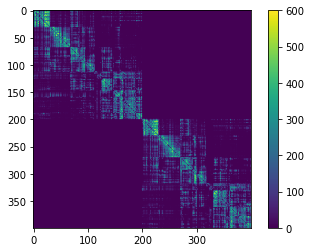

In [97]:
plt.imshow(sum(binary_top_fc_F))
plt.colorbar()
plt.clim(0, 600)
plt.show()

#### Matrix left hemisphere

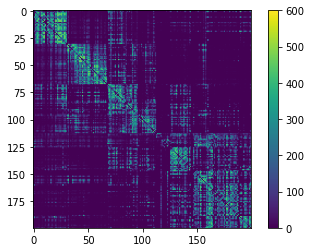

In [96]:
plt.imshow(sum(binary_top_fc_M)[:200, :200])
plt.colorbar()
plt.clim(0, 600)
plt.show()

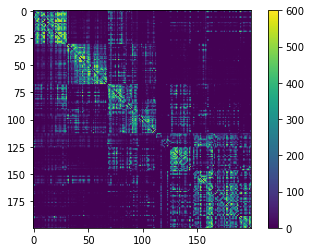

In [99]:
plt.imshow(sum(binary_top_fc_F)[:200, :200])
plt.colorbar()
plt.clim(0, 600)
plt.show()

In [115]:
for i range(400):
    

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [131]:
len(binary_top_fc_M)

464

In [130]:
binary_top_fc.shape

(1000, 400, 400)

In [141]:
binary_top_fc.T[0].shape

(400, 1000)

In [124]:
len(binary_top_fc.T[0].T)

1000

In [128]:
binary_top_fc_M.T[0][0].shape

(464,)

## Test sex differences in connectivity profiles 

Via:
- Chi-square test of indepndence (H0) of variables in contingency table to test the indepdence of variables "sex" (rows) and "area is/is not in top 10% of functional connections" (columns) -> non-independence == sex differences in top 10% of connections
- Odds Ratio (effect size)

Explanation:
- for every row (parcel) in binary matrix, for ever parcel in row of binary matrix -> make a contingency table 
- for contingency table, need to a) count the number of males and females (separately) that have this area marked (with a 1) as being one of the top 10% of connections (simply take the sum across subjects for this cell in matrix given that if area is not in top 10% of connections, it is marked with 0) and b) deduce the counts of subjects for which this areas is not part of top 10% connections
- With contingency table, can compute a) Chi-square test of independence of variables, b) (from contents of table) the Odds Ratio

In [190]:
# list that will contain the matrix of p values for the Chi-square test of independence of variables in contingency table to see sex differences in top 10% of connections
chisquare_pval_matrix = []

# list that will contain the matrix of Odds Ratio from contingency table (to-be-used as effect size for Chi-square test of indepndence of variables)
OR_matrix = []

        
# transposing the binary_top_fc array in order to have it in shape 400 x 400 x N -> iterating over 400 parcels
for i in range(len(binary_top_fc.T)):
    
    # temporary lists that will contail the rows of the chisquare_pval_matrix and OR_matrix
    temp_row_chisquare_pval_matrix = []
    temp_row_OR_matrix = []
    
    
    # iterating over 400 parcels
    for j in range(len(binary_top_fc.T[0])):
        
        # only run Chi-square test if i and j are not the same (otherwise we're at the intersection of the parcel's connection with itself in the matrix, and the value for it is 0 (i.e., not chosen as a top connection))
        if i != j:
        
            ### creating contingency table with counts of occurances for Chi-square test of indepndence of variables to test if there are statistically significant sex differences in top 10% of fc connections
            # C: connection (area) in top 10%; NC: connection (area) not in top 10%; m: male; f: female
            # row: male (top), female (bottom)
            # columns: C (left), NC right

            contingency_table = []
            Cm = 0
            NCm = 0
            Cf = 0
            NCf = 0
            
            
            ## male row
            Cm = sum(binary_top_fc_M.T[i][j])
            NCm = len(binary_top_fc_M) - Cm  # number of male subjects minus sum of counts in the top 10%

            # append male row to table
            contingency_table.append([Cm, NCm])


            ## female row
            Cf = sum(binary_top_fc_F.T[i][j])
            NCf = len(binary_top_fc_F) - Cf  # number of male subjects minus sum of counts in the top 10%

            # append female row to table
            contingency_table.append([Cf, NCf])

            contingency_table = np.array(contingency_table)
            
            
            # compute Odds Ratio (regardless of pvalue of Chi-square test)
            OR = (Cm/NCm)/(Cf/NCf)
            
            # append OR to row
            temp_row_OR_matrix.append(OR)
            
            
            # only run Chi-square test if there aren't just zeros in both columns (ie either male or female has area as one of top connections (totC > 0) or not all males and all females have area chosen as top connection (totNC > 0) - otherwise throws an error
            if (Cm + Cf > 0) and (NCm + NCf > 0):
                ### Chi-square test of independence of variables in a contingency table, [1] indexes the p val
                p_val = stats.chi2_contingency(contingency_table)[1]

                # append p value to row
                temp_row_chisquare_pval_matrix.append(p_val)
                
            else:
                # append value of 1 to matrix row because both males and females have a value of 0 for this cell in matrix therefore p > 0.05 anyway (no difference) 
                temp_row_chisquare_pval_matrix.append(1)
        
        else:
            # append value of 1 to matrix row  because we're at the intersection of the parcel's connection with itself in the matrix
            temp_row_chisquare_pval_matrix.append(1)
            
        
    # append row to full matrix
    chisquare_pval_matrix.append(temp_row_chisquare_pval_matrix)
    OR_matrix.append(temp_row_OR_matrix)
    
    
chisquare_pval_matrix = np.array(chisquare_pval_matrix)
OR_matrix = np.array(OR_matrix)

------ 0------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273

ValueError: The internally computed table of expected frequencies has a zero element at (0, 1).

In [191]:
i = 4
j = 3

contingency_table = []

## male row
Cm = sum(binary_top_fc_M.T[i][j])
NCm = len(binary_top_fc_M) - Cm  # number of male subjects minus sum of counts in the top 10%

# append male row to table
contingency_table.append([Cm, NCm])


## female row
Cf = sum(binary_top_fc_F.T[i][j])
NCf = len(binary_top_fc_F) - Cf  # number of male subjects minus sum of counts in the top 10%

# append female row to table
contingency_table.append([Cf, NCf])

contingency_table = np.array(contingency_table)
contingency_table

array([[464,   0],
       [536,   0]])

In [186]:
Cm

0

In [172]:
contingency_table

array([[  0, 464],
       [  0, 536]])

In [136]:
142+322

464

In [137]:
260+276

536

In [138]:

# Chi-square test of independence of variables in a contingency table
stats.chi2_contingency(contingency_table)

(32.422605216832274,
 1.2403520562358029e-08,
 1,
 array([[186.528, 277.472],
        [215.472, 320.528]]))

In [139]:

# Chi-square test of independence of variables in a contingency table, [1] indexes the p val
stats.chi2_contingency(contingency_table)[1]

1.2403520562358029e-08

In [157]:
i = 1
j= 1

contingency_table = []

## male row
Cm = sum(binary_top_fc_M.T[i][j])
NCm = len(binary_top_fc_M) - Cm  # number of male subjects minus sum of counts in the top 10%

# append male row to table
contingency_table.append([Cm, NCm])


## female row
Cf = sum(binary_top_fc_F.T[i][j])
NCf = len(binary_top_fc_F) - Cf  # number of male subjects minus sum of counts in the top 10%

# append female row to table
contingency_table.append([Cf, NCf])

contingency_table = np.array(contingency_table)


In [158]:
p_val = stats.chi2_contingency(contingency_table)[1]

ValueError: The internally computed table of expected frequencies has a zero element at (0, 0).

# MAKE A MATRIX WITH P VALS

In [206]:
i = 1
j = 0

Cm = 1
Cf = 0

if (i + j > 0) and (Cm + Cf > 0):
    print("ok")
    
else:
    print("else")

ok


In [167]:
contingency_table =[]

## male row
Cm = 0
NCm = len(binary_top_fc_M) - Cm  # number of male subjects minus sum of counts in the top 10%

# append male row to table
contingency_table.append([Cm, NCm])


## female row
Cf = 0
NCf = len(binary_top_fc_F) - Cf  # number of male subjects minus sum of counts in the top 10%

# append female row to table
contingency_table.append([Cf, NCf])

contingency_table = np.array(contingency_table)


In [168]:
contingency_table

array([[  0, 464],
       [  0, 536]])

In [125]:
HCP_demographics_cleaned_final.Gender

1       M
2       F
3       M
4       M
5       F
       ..
1200    F
1201    M
1202    F
1203    M
1205    F
Name: Gender, Length: 1000, dtype: object